In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = pd.read_csv('transacaoCartao.csv', sep=';', decimal=',')
df['datatrimestre'] = pd.to_datetime(df['datatrimestre'])

Corrigir vírgula e ponto nos campos de valor

In [47]:
for col in df.columns:
    if col.startswith('valor'):
        df[col] = df[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        df[col] = df[col].astype(float)

Para garantir que os dados estão Ordenados

In [48]:
df = df.sort_values('datatrimestre')

### ANÁLISE DE CORRELAÇÃO

Correlação é uma medida estatística que indica a força e a direção da relação entre duas variáveis. Quando duas variáveis estão correlacionadas, significa que mudanças em uma tendem a estar associadas a mudanças na outra.

Se a correlação é positiva, as duas variáveis aumentam ou diminuem juntas.

Se é negativa, quando uma sobe, a outra tende a descer.

Uma correlação próxima de zero indica pouca ou nenhuma relação linear entre elas.

A forma mais comum de medir correlação é o coeficiente de correlação de Pearson, que varia de -1 a 1:

1 = correlação perfeitamente positiva

0 = nenhuma correlação linear

-1 = correlação perfeitamente negativa

Importante: correlação não implica causalidade — duas variáveis podem estar relacionadas sem que uma cause a outra.

<Axes: >

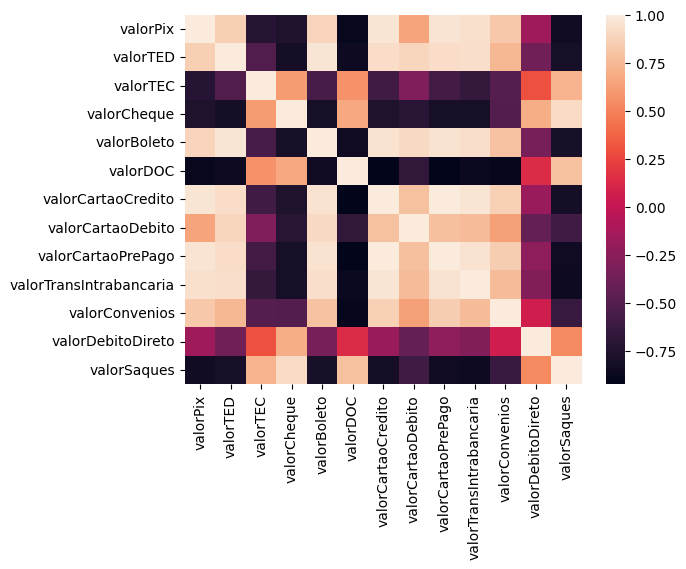

In [35]:
correlacao = df[[col for col in df.columns if col.startswith('valor')]].corr()
sns.heatmap(correlacao)

Como estamos tentando prever o gasto com cartão de crédito podemos limitar ao estudo de correlação só para a variável de interesse.

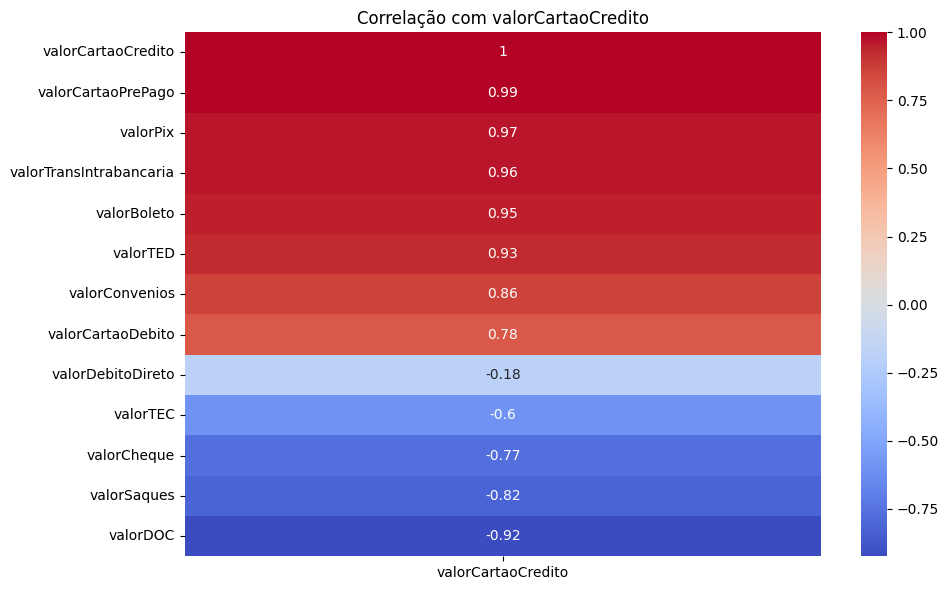

In [36]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlacao[['valorCartaoCredito']].sort_values(by='valorCartaoCredito', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlação com valorCartaoCredito')
plt.tight_layout()
plt.show()

### Random Forest

In [37]:
X_import = df.drop(columns=['valorCartaoCredito', 'datatrimestre'])
y_import = df['valorCartaoCredito']

modelo_temp = RandomForestRegressor(n_estimators=200, random_state=42)
modelo_temp.fit(X_import, y_import)

importancias = pd.Series(modelo_temp.feature_importances_, index=X_import.columns)
importantes = importancias.sort_values(ascending=False)

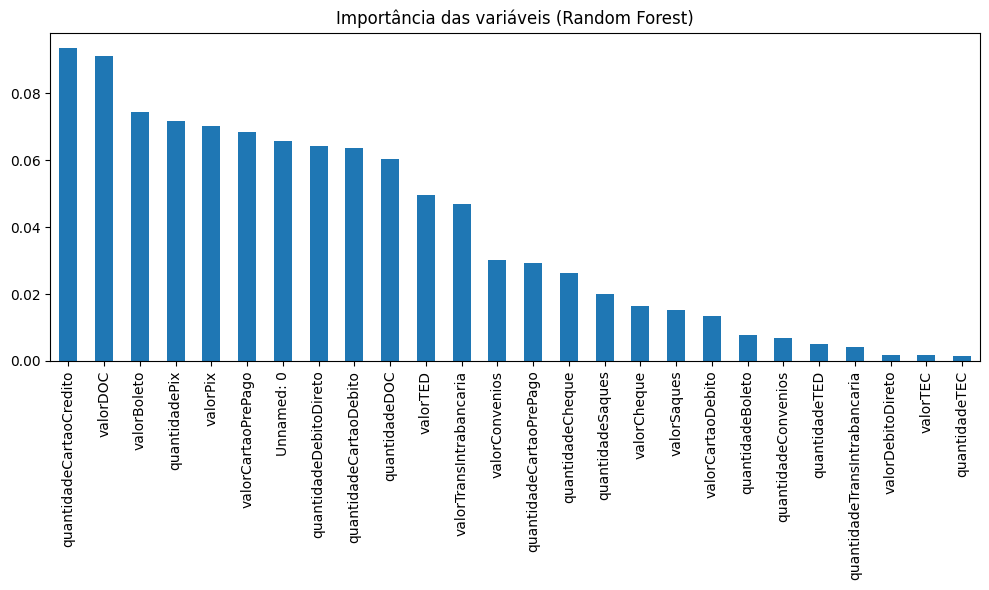

In [38]:
plt.figure(figsize=(10, 6))
importantes.plot(kind='bar')
plt.title('Importância das variáveis (Random Forest)')
plt.tight_layout()
plt.show()

RMSE: 1,133,137,502,498.68


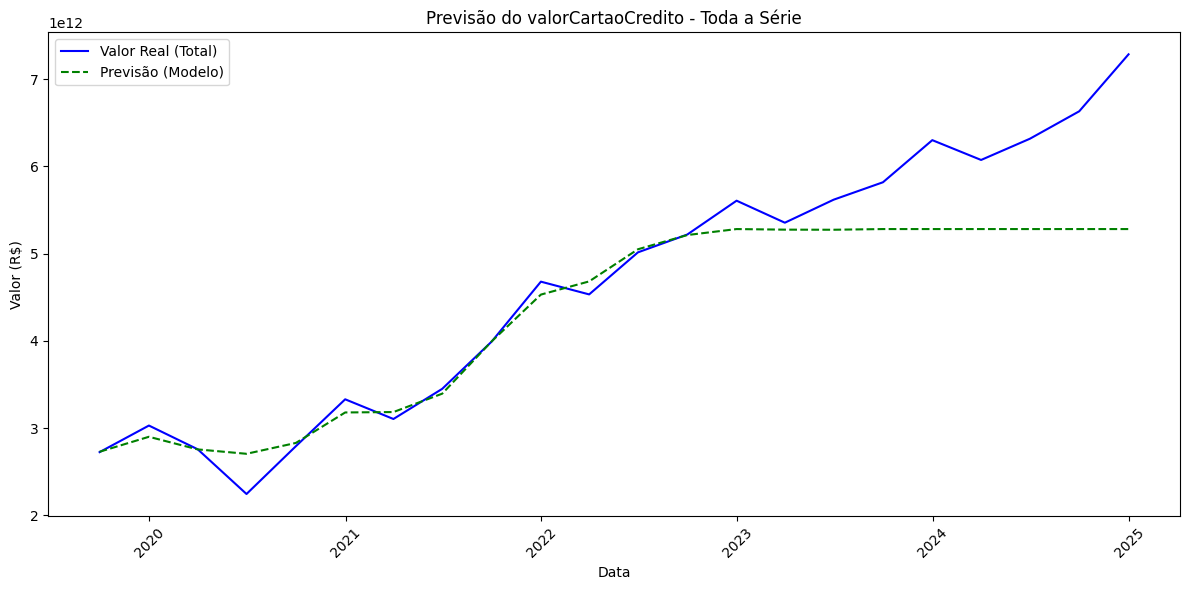

In [39]:
melhores_variaveis = importantes.head(8).index.tolist()

df['lag1'] = df['valorCartaoCredito'].shift(1)
df['lag2'] = df['valorCartaoCredito'].shift(2)

df_model = df.dropna()

X = df_model[melhores_variaveis + ['lag1', 'lag2']]
y = df_model['valorCartaoCredito']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

modelo = RandomForestRegressor(
    n_estimators=100,
    max_depth=4,
    min_samples_split=3,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:,.2f}")

y_full = np.concatenate([modelo.predict(X_train), y_pred])
datas_full = df_model['datatrimestre'].iloc[-len(y_full):]  
plt.figure(figsize=(12, 6))
plt.plot(df_model['datatrimestre'], df_model['valorCartaoCredito'], label='Valor Real (Total)', color='blue')
plt.plot(datas_full, y_full, label='Previsão (Modelo)', color='green', linestyle='--')
plt.title('Previsão do valorCartaoCredito - Toda a Série')
plt.xlabel('Data')
plt.ylabel('Valor (R$)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Esse foi o primeiro modelo obtido, perceba que ele parece estar bom em um certo momento, mas depois ele começa a errar muito.

## Tentativa 2

Para essa segunda parte vamos usar uma biblioteca que foi desenvolvida pela Meta, ela possui muitas otimizações para trabalhar com séries temporais.

obs.: Instale no seu ambiente as bibliotecas: prophet e plotly

17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing


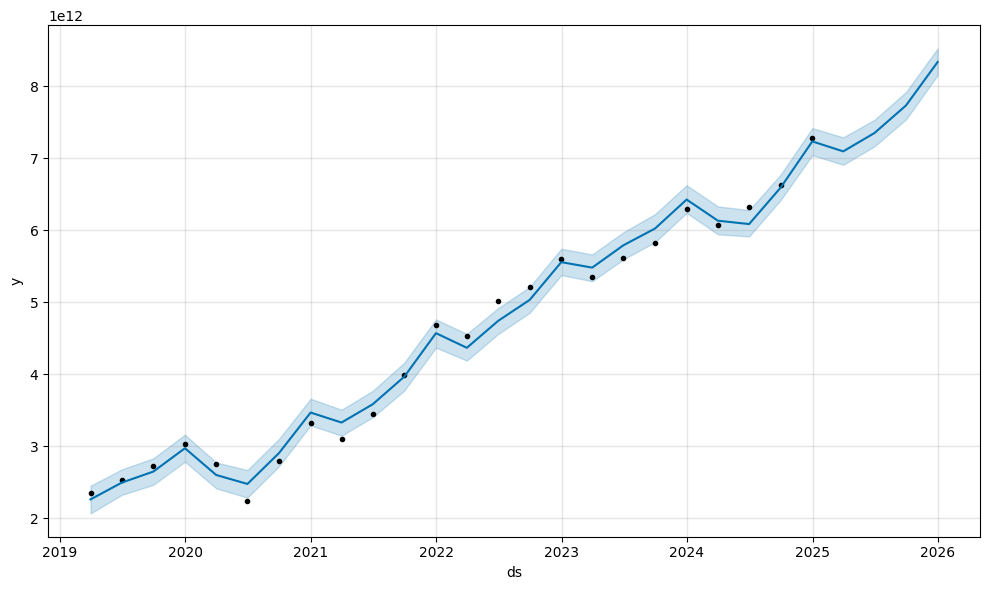

In [40]:
from prophet import Prophet
import pandas as pd


df_prophet = df[['datatrimestre', 'valorCartaoCredito']].rename(columns={
    'datatrimestre': 'ds',
    'valorCartaoCredito': 'y'
})


model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=4, freq='QE')
forecast = model.predict(future)
fig = model.plot(forecast)


17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing


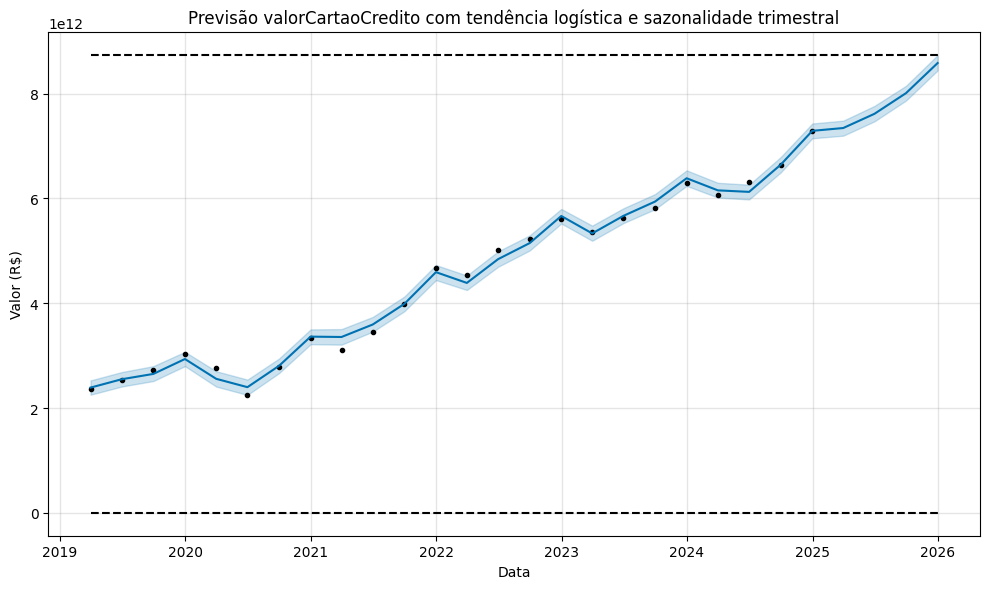

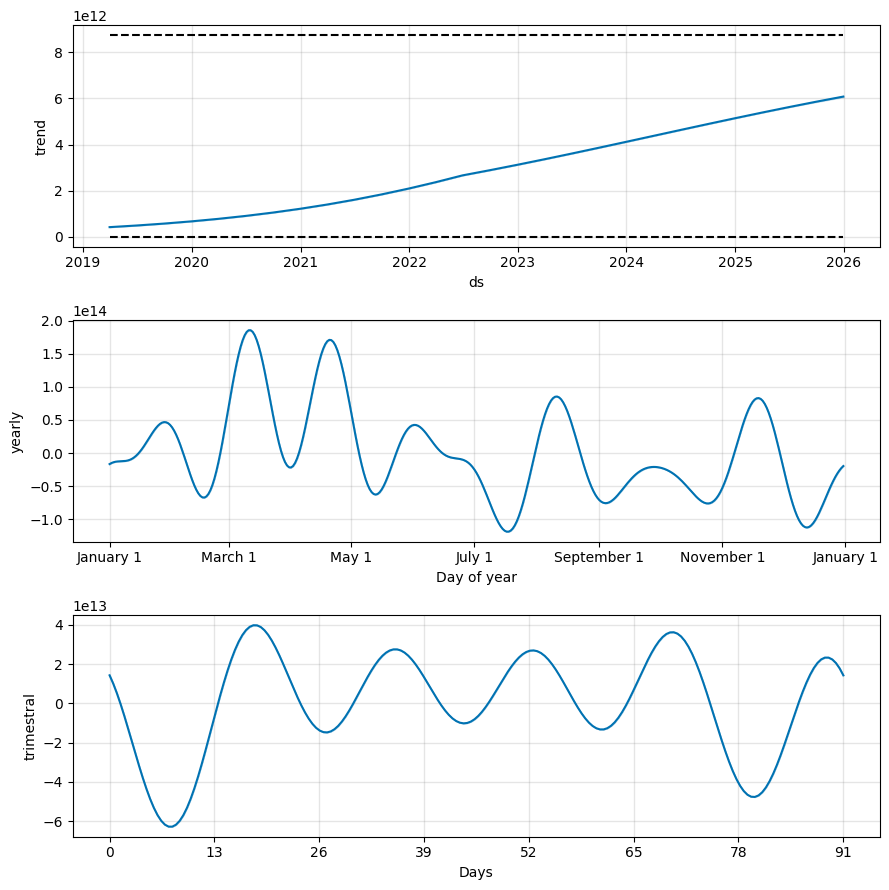

In [41]:
df_prophet = df[['datatrimestre', 'valorCartaoCredito']].rename(columns={
    'datatrimestre': 'ds',
    'valorCartaoCredito': 'y'
})

# Define limite superior ("cap") e inferior ("floor") para a série
max_val = df_prophet['y'].max()
df_prophet['cap'] = max_val * 1.2
df_prophet['floor'] = 0

model = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.3,     # Mais flexível para mudanças de tendência
    seasonality_prior_scale=10.0     # Mais liberdade para curva sazonal
)

model.add_seasonality(name='trimestral', period=365.25/4, fourier_order=5)


model.fit(df_prophet)

future = model.make_future_dataframe(periods=4, freq='QE')
future['cap'] = df_prophet['cap'].max()
future['floor'] = 0

forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title("Previsão valorCartaoCredito com tendência logística e sazonalidade trimestral")
plt.xlabel("Data")
plt.ylabel("Valor (R$)")
plt.tight_layout()
plt.show()


fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()


Com o modelo ajustado, podemos prever valores futuros.

In [42]:
future_only = forecast[forecast['ds'] > df_prophet['ds'].max()]
print(future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


           ds          yhat    yhat_lower    yhat_upper
24 2025-03-31  7.344639e+12  7.197742e+12  7.484650e+12
25 2025-06-30  7.615884e+12  7.471899e+12  7.767161e+12
26 2025-09-30  8.011134e+12  7.869206e+12  8.151332e+12
27 2025-12-31  8.585214e+12  8.444471e+12  8.737492e+12


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

model = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.3,
    seasonality_prior_scale=10.0
)
model.add_seasonality(name='trimestral', period=365.25/4, fourier_order=5)
model.fit(df_prophet)


future = model.make_future_dataframe(periods=4, freq='QE')  
future['cap'] = df_prophet['cap'].max()
future['floor'] = 0

17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
forecast = model.predict(future)


ultima_data_real = df_prophet['ds'].max()
historico = df_prophet.copy()
forecast_modelado = forecast[forecast['ds'] <= ultima_data_real]
forecast_futuro = forecast[forecast['ds'] > ultima_data_real]

ultimo_modelado = forecast_modelado.iloc[-1][['ds', 'yhat']]
primeiro_previsto = forecast_futuro.iloc[0][['ds', 'yhat']]

transicao = pd.DataFrame({
    'ds': [ultimo_modelado['ds'], primeiro_previsto['ds']],
    'yhat': [ultimo_modelado['yhat'], primeiro_previsto['yhat']]
})

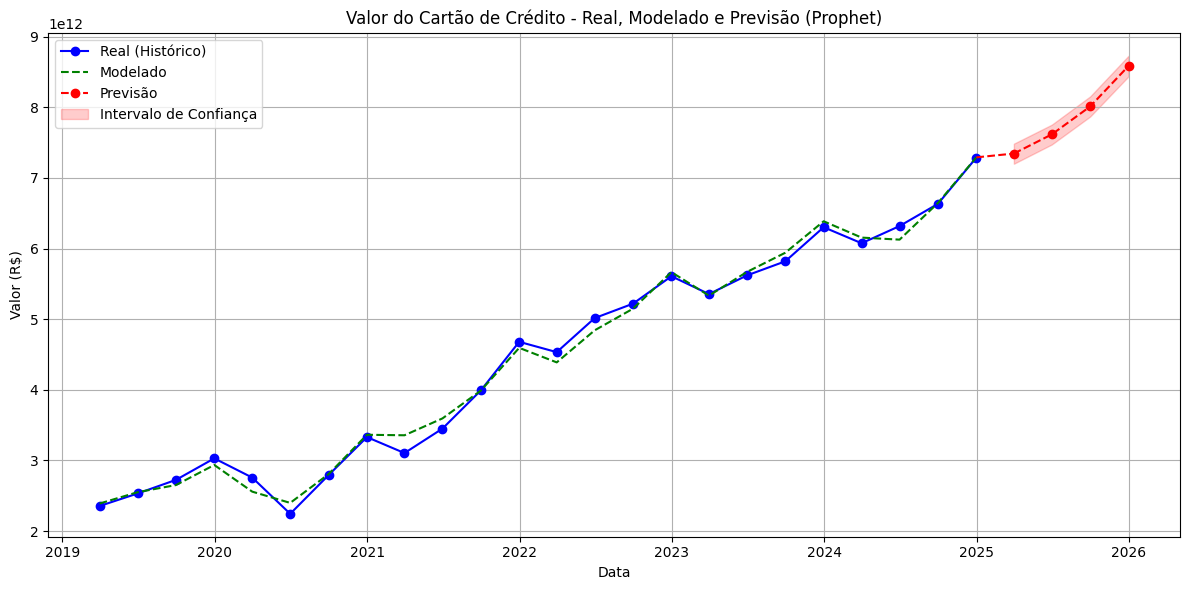

In [45]:
plt.figure(figsize=(12, 6))

plt.plot(historico['ds'], historico['y'], label='Real (Histórico)', color='blue', marker='o')
plt.plot(forecast_modelado['ds'], forecast_modelado['yhat'], label='Modelado', color='green', linestyle='--')
plt.plot(forecast_futuro['ds'], forecast_futuro['yhat'], label='Previsão', color='red', linestyle='--', marker='o')

plt.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'],
                 color='red', alpha=0.2, label='Intervalo de Confiança')


plt.plot(transicao['ds'], transicao['yhat'], color='red', linestyle='--')  # linha de conexão

plt.title('Valor do Cartão de Crédito - Real, Modelado e Previsão (Prophet)')
plt.xlabel('Data')
plt.ylabel('Valor (R$)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Exercício: Adaptar o código acima para uma outra variável do banco de dados.

Resposta no arquivo MachineLearning-valorConveniosEX.ipynb